## 知識情報学第8回演習サンプルプログラム ex8.ipynb
- Programmed by Ken-ichi Fukui and Nat Pavasant
- Last updated: 2022/09/06
- Checked with Python 3.8.16, scikit-learn 1.3.2
- MIT License

## 糖尿病の進行度推定と特徴選択

In [1]:
%matplotlib inline
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
import matplotlib.pyplot as plt

### Diabetesデータのロード

In [46]:
df = load_diabetes()
X = scale(df.data)
y = df.target
df.feature_names = np.array(df.feature_names)

print(df.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

## 線形回帰＋逐次特徴選択（SFS）
- SequentialFeatureSelector:
  - https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html
- 学習データ（50%）で特徴選択を行い，テストデータ（50%）に対して交差検証を行う

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state=2)

### 1．特徴選択を行わない線形回帰

In [4]:
lr = LinearRegression()
scores = cross_val_score(lr, X_test, y_test, cv=10)
print("R2 score {:.4f}".format(scores.mean()))

R2 score 0.4250


### 2．前進特徴選択

In [12]:
lr_forward = LinearRegression()
# 課題1(a). SequentialFeatureSelectorを前進特徴選択，選択特徴数5, 交差検証のFold数5でインスタンス生成（初期化）する
sfs_forward = SequentialFeatureSelector(lr_forward, n_features_to_select=5, cv=5)
sfs_forward.fit(X_train, y_train)

# get_support()で選択された特徴量のMaskが取得できる
print("Selected feature mask:", sfs_forward.get_support())
# 選択された特徴名の表示
print("Selected feature names:", df.feature_names[sfs_forward.get_support()])

Selected feature mask: [False  True  True  True False False  True False  True False]
Selected feature names: ['sex' 'bmi' 'bp' 's3' 's5']


In [13]:
# 課題1(b). テストデータを選択された特徴のみに削減
X_test_selected1 = sfs_forward.transform(X_test)
# 特徴数が削減されていることを確認
print(X_test_selected1.shape)

lr_selected1 = LinearRegression()
scores = cross_val_score(lr_selected1, X_test_selected1, y_test, cv=10)
print("R2 score {:.4f}".format(scores.mean()))

(221, 5)
R2 score 0.4216


### 3．後退特徴選択

In [14]:
# 課題1(c). 上記の2同様にして後退特徴選択を行う
lr_backward = LinearRegression()
sbs_backward = SequentialFeatureSelector(lr_backward, n_features_to_select=5, cv=5, direction='backward')
sbs_backward.fit(X_train, y_train)

print("Selected feature mask:", sbs_backward.get_support())
print("Selected feature names:", df.feature_names[sbs_backward.get_support()])

X_test_selected2 = sbs_backward.transform(X_test)
print(X_test_selected2.shape)

lr_selected2 = LinearRegression()
scores = cross_val_score(lr_selected2, X_test_selected2, y_test, cv=10)
print("R2 score {:.4f}".format(scores.mean()))

Selected feature mask: [False  True  True  True False False  True False  True False]
Selected feature names: ['sex' 'bmi' 'bp' 's3' 's5']
(221, 5)
R2 score 0.4216


## モデルベース特徴選択
- 特徴量の重要度の算出が可能なモデルをベースとした特徴選択
- SelectFromModel: 
  - https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html
  
### 1. Lasso回帰
- Lasso:
  - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [15]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

In [16]:
lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)
# 学習済み重みを表示
lasso.coef_

array([ -0.19512245, -12.45996611,  18.73751335,  16.13507338,
        -0.        ,  -3.37480673, -11.11897238,  -0.        ,
        30.92342405,   1.46927353])

### 重要度に基づいた特徴選択
- 非ゼロ要素が選択される

In [17]:
lasso_selected = SelectFromModel(lasso, prefit=True)
X_test_selected3 = lasso_selected.transform(X_test)
print(X_test_selected3.shape)
print("Selected feature names:", df.feature_names[lasso_selected.get_support()])

scores = cross_val_score(lasso, X_test_selected3, y_test, cv=10)
print("R2 score {:.4f}".format(scores.mean()))

(221, 8)
Selected feature names: ['age' 'sex' 'bmi' 'bp' 's2' 's3' 's5' 's6']
R2 score 0.4199


### 2．決定木ベース
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [18]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [48]:
dtr = DecisionTreeRegressor(max_depth=4)
dtr.fit(X_train, y_train)
# 課題1(d). 決定木による重要度の表示
print(dtr.feature_importances_)

[0.0689417  0.01483668 0.12747315 0.08302312 0.02868456 0.
 0.         0.         0.60024634 0.07679445]


### 特徴選択前の決定木の描画

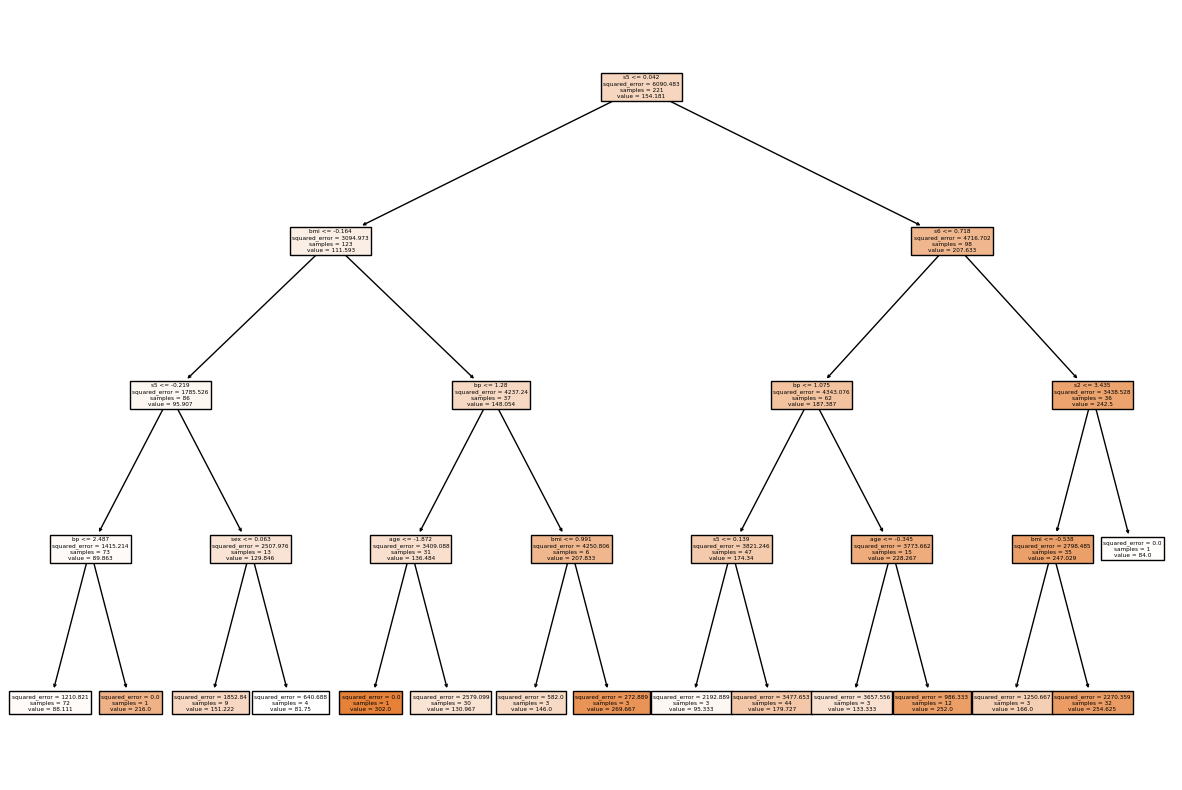

In [33]:
plt.figure(figsize=(15, 10))
plot_tree(dtr, feature_names=df.feature_names, filled=True)
plt.show()

### 課題1(e). 重要度に基づいた特徴選択
- SelectFromModelを用いて特徴選択を行い，テストデータを選択された特徴のみに削減する
- 選択された特徴名を表示する
- テストデータに対して10Fold-交差検証を行い平均R2スコアを表示する

In [49]:
dtr_selected = SelectFromModel(dtr, prefit=True)
print("Selected feature names:", df.feature_names[dtr_selected.get_support()])
X_test_selected3 = dtr_selected.transform(X_test)
scores = cross_val_score(dtr, X_test_selected3, y_test, cv=10)
print("Average R2 score: {:.4f}".format(scores.mean()))

Selected feature names: ['bmi' 's5']
Average R2 score: 0.3139


### 課題1(f). 特徴選択後の決定木の描画
- 学習データに対して選択された特徴のみで決定木を再学習し描画する

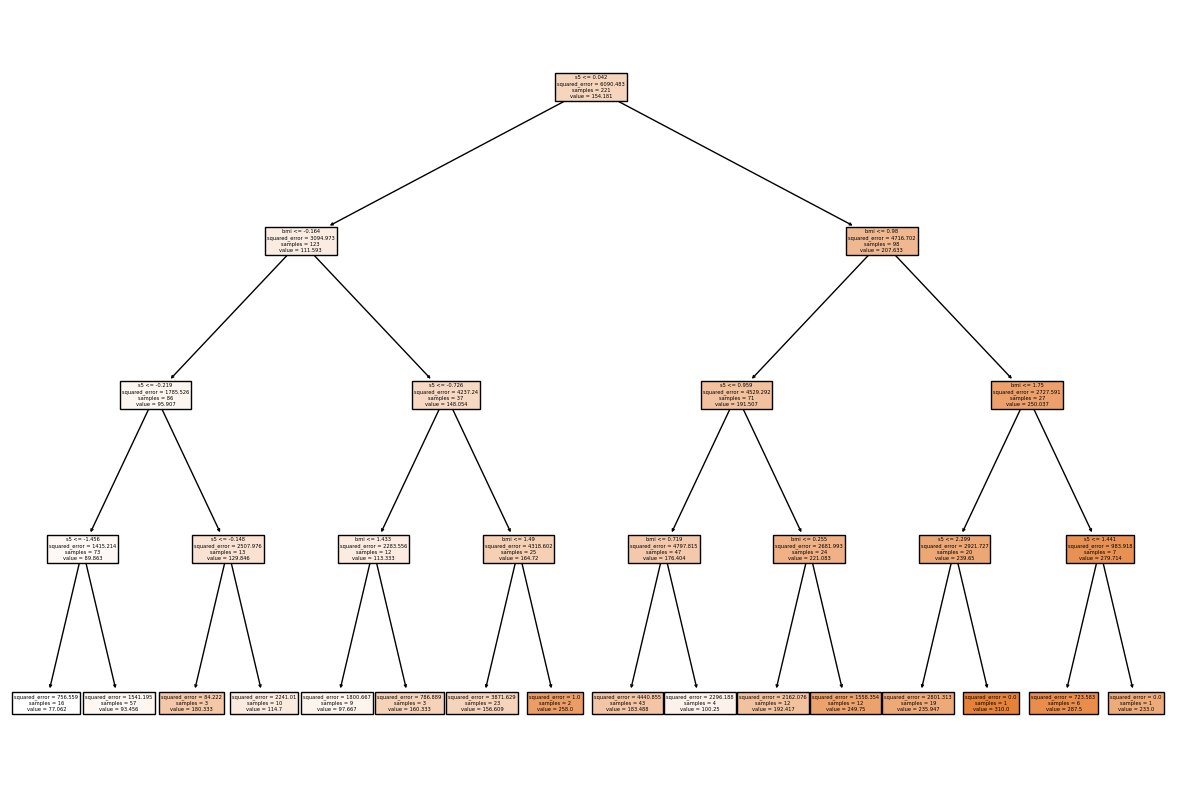

In [54]:
selected_features = df.feature_names[dtr_selected.get_support()]
X_train_selected = dtr_selected.transform(X_train)
dtr.fit(X_train_selected, y_train)
plt.figure(figsize=(15, 10))
plot_tree(dtr, feature_names=selected_features, filled=True)
plt.show()

## 課題2

- 全ての特徴選択手法においてbmi, s5が選ばれていることから、これらは大きく予測に寄与する特徴量だと考えられる
- 上記以外では、Lasso回帰の係数は絶対値が大きい順にbp, sex, s3, s2, s6, ageになっており、このうち上位３つのbp, sex, s3は前進逐次特徴選択においても選ばれている
- 全ての特徴選択手法において特徴量の選択順序は一致していたが、使用する特徴の個数は異なっていた。
- 8個の特徴量を使用したLasso回帰と５つの特徴量を使用した線形回帰は同程度のR2スコアを示しており、差分である３つの特徴量の影響は小さいと考えられる
- 一方で特徴2つだけを使用した決定木モデルは他のモデルと比較してR2スコアが大きく低下しており、使用しなかった特徴（bp, sex, s3）の影響が大きいことが窺える
- モデルベースベースの特徴選択は少ない計算量で各特徴の重要度を調べることができるが、その結果からどの特徴を選択するかによって最終的な予測精度に大きく影響を与えることが分かった
- 近年よく使われているLightGBMモデルは学習時間が短いだけでなく、特徴量の重要度を調べることができることからデータサイエンスにおいて重宝されているということが分かった